<center><font size="6"><b>CV SEGA</b></font></center>
<p></p>
<center><font size="5"><b>Modélisation pour la prédiction de keypoints</b></font></center>
<br>
<br>
<br>

# Contexte

## Intentions

Prédire des keypoints qui constitueront un parallélépipède autour d'un container avec des images qui ne contiennent qu'un container.

Étant donnée qu'un parallélépipède est défini par 4 points et un sommet, nous n'allons travailler que sur la prédiction de 4 points. Les autres points seront déterminés par reconstruction géométrique via des fonctions.

Un micro dataset a été créé afin de tester l'approche en attendant le dataset définitif.

## Papiers de recherches

Papiers de recherche étudiés :

    - BBOX 3D
    https://arxiv.org/pdf/2006.07864.pdf
    https://arxiv.org/pdf/2012.09771.pdf

    - PINNs
    https://arxiv.org/pdf/2201.05624.pdf

# Notebook

## Versions

CV_SEGA_model_keypoints.md

## Configuration du notebook

In [1]:
# Mode d'éxécution du notebook : "drive" ou "local"
work_mode = "local"

# Localisation des modèles pour les sauvegardes et les chargements
if work_mode == "drive":
    model_loc = "/drive/My Drive/CV_DS/..."
elif work_mode == "local":
    model_loc = "_models"

In [2]:
%%javascript
// Récupération du nom du notebook
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
# Récupération du nom notebook pour les sauvegardes de modèles et connection au drive et montage du drive
if work_mode == "drive":
    # Montage du drive
    from requests import get
    theNotebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    theNotebook = theNotebook[0:-6]
    print("Nom du notebook : ",theNotebook)
    
    # Montage du drive
    from google.colab import  drive
    drive.mount('/content/drive')

## Installer

In [4]:
if work_mode == "drive":
    !pip install tensorflow_addons

# Modules et fonctions

## Import des modules


In [5]:
# Classics
import pandas as pd
import numpy as np
import random

# Opérations sur fichiers/dossiers
import os
from joblib import load, dump
import json
from glob import glob

# Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
%matplotlib inline

# Autres
from tqdm import tqdm
from collections import Counter
import pprint

# Tensorflow
import tensorflow as tf

# Preprocess
from sklearn.model_selection import train_test_split

## La cuisine

In [6]:
# Fonction d'exploration de l'arborescence des json
def json_tree (file):
    tree_str = json.dumps(file, indent=4)
    tree_str = tree_str.replace("\n    ", "\n").replace('"', "").replace(',', "").replace("{", "")
    tree_str = tree_str.replace("}", "").replace("    ", " | ").replace("  ", " ")
    return print(tree_str)

In [7]:
# Fonction d'affichage d'une image et des keypoints associés
def show_img_keypoints (img, coords):
    
    # Calcul des coordonnées
    img_width = img.shape[1]
    img_height = img.shape[0]

    # Affichage de l'image
    plt.imshow(img)
    
    # Affichage des keypoints
    for i in list(range(0,len(coords),2)):
        plt.plot(coords[i]*img_width,
                 coords[i+1]*img_height,
                 marker="o",
                 markersize=10,
                 markeredgecolor="yellow",
                 markerfacecolor="blue")


## Test GPU

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sys_details = tf.sysconfig.get_build_info()
if tf.test.gpu_device_name():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found : {device_name}')
    pprint.pprint(sys_details)
else:
    tf.config.list_physical_devices('CPU')
    print("No GPU found, CPU mode activated")
    pprint.pprint(sys_details)

No GPU found, CPU mode activated
OrderedDict([('cpu_compiler',
              'C:/Program Files (x86)/Microsoft Visual '
              'Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '64_112'),
             ('cudart_dll_name', 'cudart64_112.dll'),
             ('cudnn_dll_name', 'cudnn64_8.dll'),
             ('cudnn_version', '64_8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False),
             ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'),
             ('nvcuda_dll_name', 'nvcuda.dll')])


# Chargement du dataset

In [10]:
# Récupération de la liste des fichiers composants le dataset nommé dataset
if work_mode == "local":
#     path_1 = "E:/OneDrive/_forge/SEGA/datasets/container"
    path_1 = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/keypoints"
elif work_mode == "drive":
    path_1 = "drive/My Drive/CV_DS/_data/keypoints"

files_list_1 = os.listdir(path_1)

# Construction du dataset 1
df_1 = pd.DataFrame({"file_name" : files_list_1})
df_1

,file_name
0,00048.jpeg
1,00050.jpeg
2,00052.jpeg
3,00056.jpeg
4,00060.jpeg
...,...
88,00899.jpeg
89,00901.jpeg
90,00915.jpeg
91,keypoints_containers_22071.json


In [11]:
# Exploration de l'arborescence des json
json_path = os.path.join(path_1,df_1.loc[91,"file_name"])
json_tree (json.load(open(json_path, 'r')))


_via_settings: 
 | ui: 
 | | annotation_editor_height: 25
 | | annotation_editor_fontsize: 0.8
 | | leftsidebar_width: 18
 | | image_grid: 
 | | | img_height: 80
 | | | rshape_fill: none
 | | | rshape_fill_opacity: 0.3
 | | | rshape_stroke: yellow
 | | | rshape_stroke_width: 2
 | | | show_region_shape: true
 | | | show_image_policy: all
 | | 
 | | image: 
 | | | region_label: __via_region_id__
 | | | region_color: __via_default_region_color__
 | | | region_label_font: 10px Sans
 | | | on_image_annotation_editor_placement: NEAR_REGION
 | | 
 | 
 | core: 
 | | buffer_size: 18
 | | filepath: 
 | | default_filepath: Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/keypoints
 | 
 | project: 
 | | name: keypoints_containers_22071
 | 

_via_img_metadata: 
 | 00048.jpeg12376: 
 | | filename: 00048.jpeg
 | | size: 12376
 | | regions: [
 | | | 
 | | | | shape_attributes: 
 | | | | | name: point
 | | | | | cx: 11
 | | | | | cy: 78
 | | | | 
 | | | | region_attributes: 
 | 

In [12]:
# Fonction de lecture d'un fichier json au format coco et de conversion en pandas dataframe
import json
from pandas.io.json import json_normalize

# Ouverture du fichier json
with open(json_path, 'r') as f:
    data = json.load(f)

# Récupération des données d'image dans un dictionnaire
new_dict = data["_via_img_metadata"]

# Instanciation du dictionnaire final
final_dict = {}

# Boucle principale de traitement
for i in new_dict.keys():

    # Récupération des keypoints
    regions_list = new_dict[i]['regions']
    
    # Init d'un compteur pour renommer les coordonnées
    cpt = 0
    
    # Boucle d'itération au travers des coordonnées
    for region in regions_list:

        # Suppression de la clé "name"
        region['shape_attributes'].pop('name', None)
        
        # Création d'un sous dictionnaire pour la manipulation des noms de clés
        region_dict = region['shape_attributes']
        
        #renommage des clés
        region_dict[f"cx{cpt}"] = region_dict.pop('cx')
        region_dict[f"cy{cpt}"] = region_dict.pop('cy')
        
        # Construction du dictionnaire
        if cpt == 0:
            final_dict[new_dict[i]['filename']] = region_dict
        else:
            final_dict[new_dict[i]['filename']].update(region_dict)       
        
        # Incrément du compteur pour nommer les coordonnées
        cpt += 1
        
# Transposition du dataset
df = pd.DataFrame(final_dict).transpose().reset_index()

# Renommage de la première colonne
df.rename(columns={"index": "file_name"}, inplace=True)

# Récupération des dimensions des images
for i in tqdm(list(df.index)):
    img = plt.imread(os.path.join(path_1,df.loc[i,"file_name"]))
    df.loc[i,"width"] = img.shape[1]
    df.loc[i,"height"] = img.shape[0]
    
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 133.50it/s]


,file_name,cx0,cy0,cx1,cy1,cx2,cy2,cx3,cy3,width,height
0,00048.jpeg,11,78,20,126,252,69,28,54,275.0,183.0
1,00050.jpeg,158,76,158,166,9,58,244,60,259.0,194.0
2,00052.jpeg,53,65,64,193,33,34,236,50,259.0,194.0
3,00056.jpeg,143,100,149,152,57,48,223,66,300.0,168.0
4,00060.jpeg,284,233,286,540,774,145,30,122,800.0,629.0


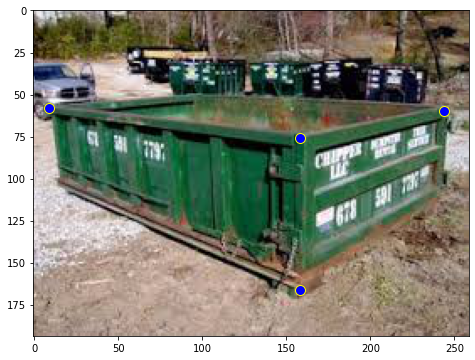

In [13]:
i = 1 
img = plt.imread(os.path.join(path_1,df.loc[i,"file_name"]))
plt.figure(figsize=(14, 6))
plt.plot(df.loc[i,"cx0"], df.loc[i,"cy0"] , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.plot(df.loc[i,"cx1"], df.loc[i,"cy1"] , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.plot(df.loc[i,"cx2"], df.loc[i,"cy2"] , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.plot(df.loc[i,"cx3"], df.loc[i,"cy3"] , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.imshow(img);

In [14]:
# Normalisation des coorodnnées x
for i in ['cx0','cx1','cx2','cx3']:
    df[i] = df[i] / df['width']

# Normalisation des coorodnnées y
for i in ['cy0','cy1','cy2','cy3']:
    df[i] = df[i] / df['height']

df.head()

,file_name,cx0,cy0,cx1,cy1,cx2,cy2,cx3,cy3,width,height
0,00048.jpeg,0.040000,0.426230,0.072727,0.688525,0.916364,0.377049,0.101818,0.295082,275.0,183.0
1,00050.jpeg,0.610039,0.391753,0.610039,0.855670,0.034749,0.298969,0.942085,0.309278,259.0,194.0
2,00052.jpeg,0.204633,0.335052,0.247104,0.994845,0.127413,0.175258,0.911197,0.257732,259.0,194.0
3,00056.jpeg,0.476667,0.595238,0.496667,0.904762,0.190000,0.285714,0.743333,0.392857,300.0,168.0
4,00060.jpeg,0.355000,0.370429,0.357500,0.858506,0.967500,0.230525,0.037500,0.193959,800.0,629.0


''

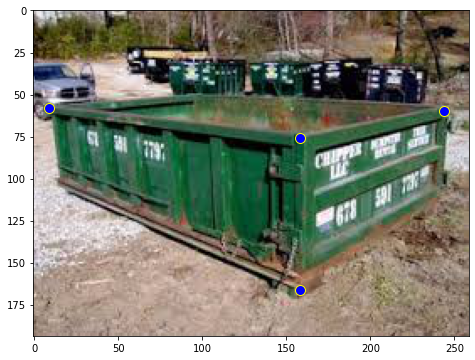

In [15]:
i = 1 
img = plt.imread(os.path.join(path_1,df.loc[i,"file_name"]))
plt.figure(figsize=(14, 6))
img_width = img.shape[1]
img_height = img.shape[0]
plt.plot(df.loc[i,"cx0"]*img_width, df.loc[i,"cy0"]*img_height , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.plot(df.loc[i,"cx1"]*img_width, df.loc[i,"cy1"]*img_height , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.plot(df.loc[i,"cx2"]*img_width, df.loc[i,"cy2"]*img_height , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.plot(df.loc[i,"cx3"]*img_width, df.loc[i,"cy3"]*img_height , marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="blue")
plt.imshow(img)
;

In [16]:
# Conversion en string de file_name
df = df.astype({'file_name':'string'})

# Construction des chemin des images
df["file_path"] = df["file_name"].apply(lambda x: path_1 + "/" + x)

# Conversion en string de file_path
df = df.astype({'file_path':'string'})

# Preprocessing

## Séparation

In [17]:
################ Réalisation des sets d'entrainnement et de tests
"""
    taille du set de test => 10 % des données restantes
    random_state => 42
"""

X_train, X_test, y_train, y_test = train_test_split(df.file_path.to_list(),
                                                    df.iloc[:,1:9].to_numpy(),
                                                    train_size=0.9,
                                                    random_state=42)

## Fonctions de chargement set bennes

**Choix des dimensions d'entrée en fonction du modèle :**

    EfficientNetB0 - (224, 224, 3)
    EfficientNetB1 - (240, 240, 3)
    EfficientNetB2 - (260, 260, 3)
    EfficientNetB3 - (300, 300, 3)
    EfficientNetB4 - (380, 380, 3)
    EfficientNetB5 - (456, 456, 3)
    EfficientNetB6 - (528, 528, 3)
    EfficientNetB7 - (600, 600, 3)

In [18]:
# Définition de la taille de redimensionnement
imgRsize = (456, 456)

In [19]:
def get_random_transform(X,y):

    def V_Flip(X,y):
        X = tf.image.flip_left_right(X)
        x_up = 1 - y[0]
        new_y = tf.stack([x_up,y[1],y[2], y[3]],0)
        
        # Récupération des x et y
        x_vals = tf.concat([y[i] for i in list(range(0,len(y),2))], axis = 0, name='concat')
        y_vals = tf.concat([y[i+1] for i in list(range(0,len(y),2))], axis = 0, name='concat')
        
        # Soustraction du tenseur des x par 1
        x_vals = tf.math.subtract( tf.convert_to_tensor(1,dtype=tf.float64) , x_vals)


        y_new = tf.reshape(tf.concat([tf.reshape(x_vals,(x_vals.shape[0],1)),
                                       tf.reshape(y_vals,(y_vals.shape[0],1))
                                      ], axis = 1), 
                            shape = y.shape)
       
        return X,y_new

    def Identity(X,y):
        return X,y
        
    def img_slider(X, y):
        
        y = tf.convert_to_tensor(y)
        
        # Récupération des x et y
        x_vals = tf.concat([y[i] for i in list(range(0,len(y),2))], axis = 0, name='concat')
        y_vals = tf.concat([y[i+1] for i in list(range(0,len(y),2))], axis = 0, name='concat')

        # Find the max translation to keep the object in the image
        tx_max = -(1 - tf.math.reduce_max(x_vals, axis=None))
        tx_min = (tf.math.reduce_min(x_vals, axis=None))
        ty_max = -(1 - tf.math.reduce_max(y_vals, axis=None))
        ty_min = (tf.math.reduce_min(y_vals, axis=None))

        # Choose a random translation
        tx = np.random.uniform(tx_min.numpy(), tx_max.numpy())
        ty = np.random.uniform(ty_min.numpy(), ty_max.numpy())
        
        # Apply the transformation in the image
        X_new = tf.keras.preprocessing.image.apply_affine_transform(X.numpy(),theta=0,
                                                                    tx=tx*X.shape[1],ty=ty*X.shape[0]
                                                                    ,shear=0,zx=1,zy=1,row_axis=0,
                                                                    col_axis=1,channel_axis=2,
                                                                    fill_mode='nearest',cval=0.0,
                                                                    order=1
                                                                   )
                                                                   
        # Correct the target variable
        x_vals = x_vals.numpy()
        y_vals = y_vals.numpy()
 
             
        x_vals += -tx
        y_vals += -ty
        
        y_new = tf.reshape(tf.concat([tf.reshape(x_vals,(x_vals.shape[0],1)),
                               tf.reshape(y_vals,(y_vals.shape[0],1))
                              ], axis = 1), 
                    shape = y.shape)

        return X_new,y_new      


    # Génération aléatoire des transformations      
    p = tf.random.uniform(shape = [1], minval=0, maxval=3, dtype=tf.dtypes.int32)
    
    # Boucle de sélection
    if p == 0:
        X,y = Identity(X, y)
    elif p==1:
        X,y = V_Flip(X, y)
    elif p==2:
        X,y = img_slider(X, y)

    return X,y

In [20]:
# Fonction de chargement des images via un numpy array ou un chemin

def magic_loader (X, y, fromfile = False, resize = None, dataAugmentation = False):   
    
    y_new = y
    
    # ==== Chargement de l'image
    if fromfile == True:
        image = tf.io.read_file(X, name=None)
        image = tf.io.decode_image(image,channels=3,expand_animations=False)  
     
    else:
        image = tf.convert_to_tensor(X)
        
    image = tf.keras.applications.efficientnet.preprocess_input(image)
   
    # ==== Redimensionnement  
    if resize!= None:
        image = tf.image.resize(image,
                             size = resize,
                             method='nearest',
                             preserve_aspect_ratio=False,
                             antialias=False,
                             name=None)
    
    # ==== dataAugmentation 
    if dataAugmentation :
        image,y_new = get_random_transform(image,y_new)
    
    
    # image = tf.math.divide(image, tf.constant(255, dtype ="uint8"), name=None)
    
    y_new = tf.cast(y_new, tf.float32)
   
    return image, y_new 

index : 17
==== Avant ====
(635, 800, 3)
[0.56375    0.53228346 0.56125    0.79212598 0.77375    0.48503937
 0.11875    0.51496063]


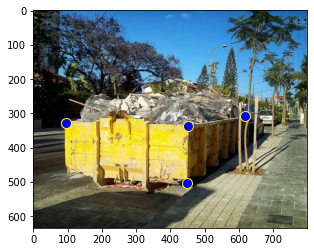

==== Après ====
(456, 456, 3)
tf.Tensor(
[0.43625    0.5322835  0.43875    0.792126   0.22625    0.48503938
 0.88125    0.51496065], shape=(8,), dtype=float32)


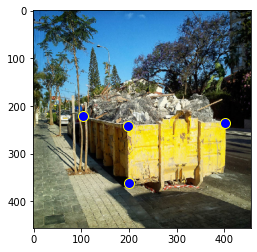

In [21]:
# ================================================================================================
# Définition de l'image pour test de la fonction de chargement d'image
i = random.choices(range(len(X_train)), k=1)[0]
img_path = X_train[i]

# ================================================================================================
# Test de la fonction
print(f"index : {i}")
image = plt.imread(img_path)
y = y_train[i]
print("==== Avant ====")
print(image.shape)
print(y)
show_img_keypoints (image, y)
plt.show()

# Application de la fonction fonctions
image_new, y_new = magic_loader(img_path, y,
                                fromfile = True,
                                resize = (imgRsize[0], imgRsize[0]),
                                dataAugmentation = True)

print("==== Après ====")
print(image_new.shape)
print(y_new)
show_img_keypoints (image_new, y_new)
plt.show()

## Générateurs de données

In [22]:
AUTO = tf.data.experimental.AUTOTUNE

# Définition des paramètres
ratio = 0.5
batch_size = 8

# Génération d'un dataset tf à partir du set d'origine
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(len(X_train)).map(lambda x, y : tf.py_function(magic_loader, [x,
                                                                                                    y,
                                                                                                    True,
                                                                                                    imgRsize,
                                                                                                    True],[tf.uint8, tf.float32]
                                                                                    ), num_parallel_calls=-1)\
                                                    .batch(int(batch_size),drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)

In [23]:
# Définition d'un générateur
def generator(dataset):
    iterator = iter(dataset)
    while True:
        X, y = next(iterator)
        yield X, y
#         try:
#             X, y = next(iterator)
#             yield X, y
#         except StopIteration:
#             return

# Définition du générateur d'entrainement.
train_generator = generator(dataset_train)

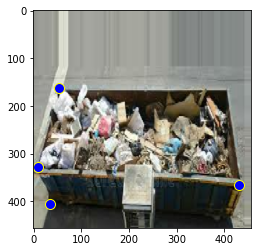

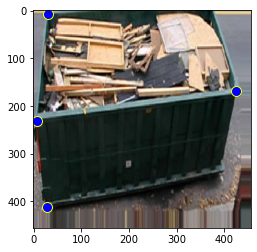

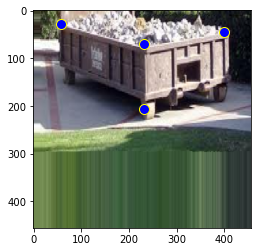

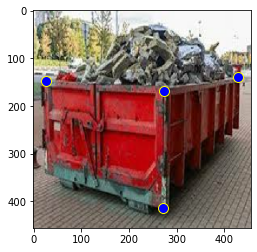

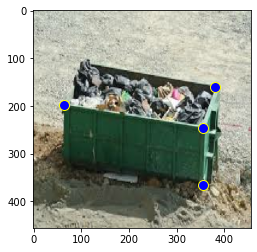

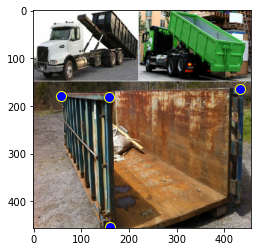

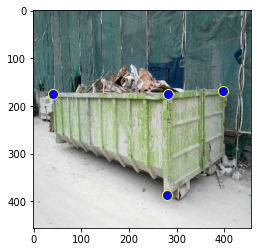

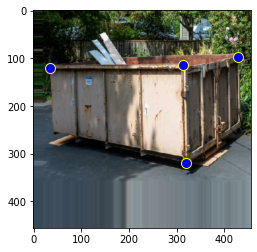

In [24]:
# Visualisation des sorties du générateur train

X_t, y_t = next(train_generator)

for img,coords in zip(X_t, y_t):
    show_img_keypoints (img, coords)
    plt.show()

In [25]:
# Test
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(len(X_test)).map(lambda x, y : tf.py_function(magic_loader, [x,
                                                                                                 y,
                                                                                                 True,
                                                                                                 imgRsize,
                                                                                                 False],[tf.uint8, tf.float32]
                                                                                    ), num_parallel_calls=-1)\
                                                    .batch(int(batch_size),drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)

# Définition du générateur de validation.
test_generator = generator(dataset_test)

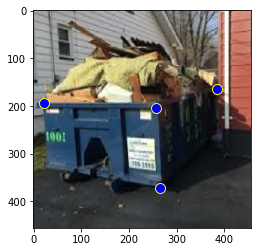

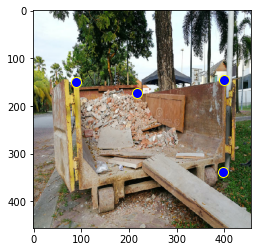

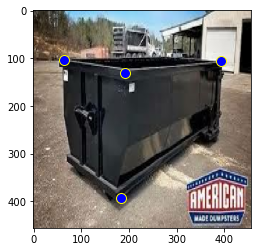

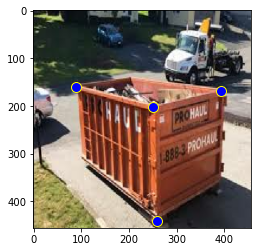

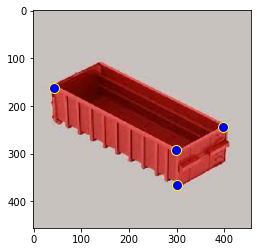

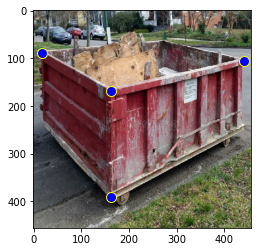

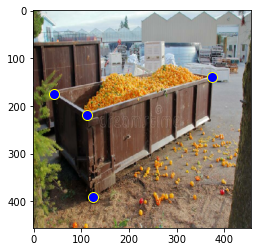

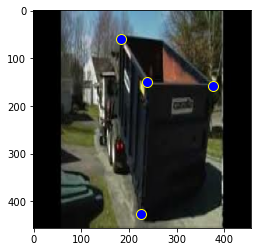

In [26]:
# Visualisation des sorties du générateur test
X_t, y_t = next(test_generator)

for img,coords in zip(X_t, y_t):
    show_img_keypoints (img, coords)
    plt.show()

# Modélisation

## Partrie encoder

In [27]:
from tensorflow.keras.applications import EfficientNetB5

# Load the model efficientNet
TL_model = EfficientNetB5(include_top=False, input_shape=(imgRsize[0],imgRsize[1],3))

# Freeze the blackbone
for layer in TL_model.layers:
    layer.trainable = False

## Partie régression

In [28]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()
model.add(TL_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

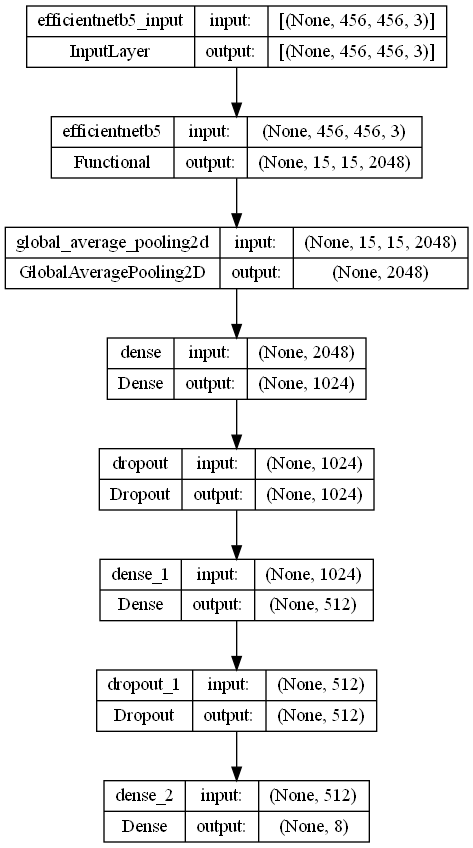

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Metrics

In [30]:
mse = tf.keras.metrics.MeanAbsoluteError()

## Fonction de perte

In [31]:
y_pred = model.predict(X_t)

1/1 [==============================] - 8s 8s/step


In [32]:
def mae (y_true, y_pred):
    mae = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mae

In [33]:
# Coordinate loss for the prediction X_t
mae(y_t, y_pred)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.529834  , 0.5707612 , 0.46438825, 0.52465653, 0.6129513 ,
       0.4856369 , 0.44460228, 0.48874348], dtype=float32)>

## Compilation

In [34]:
import tensorflow_addons as tfa

INIT_LR = 1e-4
MAX_LR = 1e-2

steps_per_epoch = len(X_train) // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
                                          maximal_learning_rate=MAX_LR,
                                          scale_fn=lambda x: 1/(2.**(x-1)),
                                          step_size=2 * steps_per_epoch
                                         )


In [35]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model.compile(loss=mae,
              optimizer=SGD(clr),
              metrics = [mse]
             )

## Callbacks

In [36]:
from tensorflow.keras import callbacks

In [37]:
# # Réduction du lr sur un plateau
# lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                          factor=0.1,
#                                          patience=3,
#                                          verbose=2,
#                                          mode='min')

In [38]:
# Callback pour l'arrêt anticipé si les perfos ne s'améliorent pas.
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

## Entrainement

In [ ]:
nb_epochs = 40
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping]
                   )

Epoch 1/40
9/9 [==============================] - 60s 5s/step - loss: 0.5002 - mean_absolute_error: 0.5002 - val_loss: 0.4400 - val_mean_absolute_error: 0.4400
Epoch 2/40
9/9 [==============================] - 43s 5s/step - loss: 0.4018 - mean_absolute_error: 0.4018 - val_loss: 0.3033 - val_mean_absolute_error: 0.3033
Epoch 3/40
9/9 [==============================] - 48s 5s/step - loss: 0.3034 - mean_absolute_error: 0.3034 - val_loss: 0.2367 - val_mean_absolute_error: 0.2367
Epoch 4/40
9/9 [==============================] - 50s 6s/step - loss: 0.2565 - mean_absolute_error: 0.2565 - val_loss: 0.2161 - val_mean_absolute_error: 0.2161
Epoch 5/40
9/9 [==============================] - 61s 7s/step - loss: 0.2649 - mean_absolute_error: 0.2649 - val_loss: 0.2108 - val_mean_absolute_error: 0.2108
Epoch 6/40
9/9 [==============================] - ETA: 0s - loss: 0.2479 - mean_absolute_error: 0.2479

In [ ]:
# Config
first_var = 'loss'
second_var = 'mean_absolute_error'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')
plt.show()

# # Config
# first_var = 'metric_confident'
# second_var = 'lr'
# history = history

# # Mise à l'échelle des nb d'epochs
# tick_locs = list(range(0,nb_epochs))
# tick_lbls = list(range(1,nb_epochs+1))

# plt.figure(figsize=(14,4))
# # Graphe var 1
# plt.subplot(121)
# plt.plot(history.history[first_var])
# plt.plot(history.history['val_'+first_var])
# plt.title(f'Model {first_var} by epoch')
# plt.ylabel(first_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.legend(['train', 'validation'], loc='best')

# # Graphe var 2
# plt.subplot(122)
# plt.plot(history.history[second_var])
# plt.title(f'Model {second_var} by epoch')
# plt.ylabel(second_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.show()

## Inférence

In [ ]:
X_t, y_t = next(test_generator)

In [ ]:
# Définition de l'image et des coordonnées pour test du modèle
i = random.choices(list(range(batch_size)), k=1)[0]
img_ori = X_t[i]
coord_ori = y_t[i]

# Affichage de la BB d'origine
print("==== Image et BB source ====")
show_img_keypoints (img_ori, coord_ori)
plt.show()

# Affichage de la BB prédite
print("==== Image et BB après prédiction ====")
coords_pred = model.predict(tf.expand_dims(img_ori, axis=0))[0]
show_img_keypoints (img_ori, coords_pred)
plt.show()

In [ ]:
for img in X_t:
    print("==== Image et BB après prédiction ====")
    coords_pred = model.predict(tf.expand_dims(img, axis=0))[0]
    show_img_keypoints (img, coords_pred )
    plt.show()

# Defreeze

In [ ]:
for layer in TL_model.layers:
    print(layer.name)
    print("========================",layer.trainable)

In [ ]:
plot_model(TL_model, show_shapes=True)

In [ ]:
# unfreeze the blackbone
for layer in TL_model.layers[-5:]:
    layer.trainable = True

In [ ]:
for layer in TL_model.layers:
    print(layer.name)
    print("========================",layer.trainable)

# Entrainement

In [ ]:
nb_epochs = 40
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping]
                   )

In [ ]:
# Config
first_var = 'loss'
second_var = 'mean_absolute_error'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 0)
plt.legend(['train', 'validation'], loc='best')
plt.show()

# # Config
# first_var = 'metric_confident'
# second_var = 'lr'
# history = history

# # Mise à l'échelle des nb d'epochs
# tick_locs = list(range(0,nb_epochs))
# tick_lbls = list(range(1,nb_epochs+1))

# plt.figure(figsize=(14,4))
# # Graphe var 1
# plt.subplot(121)
# plt.plot(history.history[first_var])
# plt.plot(history.history['val_'+first_var])
# plt.title(f'Model {first_var} by epoch')
# plt.ylabel(first_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.legend(['train', 'validation'], loc='best')

# # Graphe var 2
# plt.subplot(122)
# plt.plot(history.history[second_var])
# plt.title(f'Model {second_var} by epoch')
# plt.ylabel(second_var)
# plt.xlabel('epoch')
# plt.xticks(tick_locs, tick_lbls, rotation = 0)
# plt.show()

## Inférence

In [ ]:
# Définition de l'image et des coordonnées pour test du modèle
i = random.choices(list(range(batch_size)), k=1)[0]
img_ori = X_t[i]
coord_ori = y_t[i]

# Affichage de la BB d'origine
print("==== Image et BB source ====")
show_img_keypoints (img_ori, coord_ori)
plt.show()

# Affichage de la BB prédite
print("==== Image et BB après prédiction ====")
coords_pred = model.predict(tf.expand_dims(img_ori, axis=0))[0]
show_img_keypoints (img_ori, coords_pred)
plt.show()

In [ ]:
for img in X_t:
    print("==== Image et BB après prédiction ====")
    coords_pred = model.predict(tf.expand_dims(img, axis=0))[0]
    show_img_keypoints (img, coords_pred )
    plt.show()

# Conclusion

Le positionnement des coordonnées n'est pas assez précis. A tester avec le vrai dataset ainsi qu'une data augmentation.

# Bac à sable